In [1]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import psutil
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, pruned_params=None, quantized=False, bit_width=8):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.quantized = quantized
        self.bit_width = bit_width
        self.pruned_params = pruned_params  # Dictionary of {param_idx: importance}
        
        self.n_params = self._calculate_params()
        self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6  # Increased parameters per qubit
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params
    
    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with optional pruning"""
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                # Apply rotations only if not pruned or based on importance
                if self.pruned_params is None or param_idx in self.pruned_params:
                    qml.Rot(params[param_idx], params[param_idx + 1], 
                           params[param_idx + 2], wires=i)
                    qml.RX(params[param_idx + 3], wires=i)
                    qml.RY(params[param_idx + 4], wires=i)
                    qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern - apply only if not pruned
            for i in range(self.n_qubits - 1):
                if self.pruned_params is None or param_idx % self.n_params in self.pruned_params:
                    qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                    qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    if self.pruned_params is None or (param_idx + 1) % self.n_params in self.pruned_params:
                        qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                        qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit with optional pruning"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
        
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
        
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                # Apply rotations only if not pruned or based on importance
                if self.pruned_params is None or param_idx in self.pruned_params:
                    qml.Rot(params[param_idx], params[param_idx + 1], 
                           params[param_idx + 2], wires=i)
                    qml.RX(params[param_idx + 3], wires=i)
                    qml.RY(params[param_idx + 4], wires=i)
                    qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            for i in range(self.n_qubits - 1):
                if self.pruned_params is None or param_idx % self.n_params in self.pruned_params:
                    qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                    qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    if self.pruned_params is None or (param_idx + 1) % self.n_params in self.pruned_params:
                        qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                        qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        # Use top 2 eigenvectors with proper weighting
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices] / np.sum(eigenvals[top_indices])
        latent_state = np.sum([w * eigenvecs[:, i] for w, i in zip(weights, top_indices)], axis=0)
        return latent_state / np.linalg.norm(latent_state)
    
    def forward(self, x):
        """Forward pass with optional quantization"""
        # Apply quantization to parameters if needed
        if self.quantized:
            quantized_params = self.quantize_parameters(self.params)
        else:
            quantized_params = self.params
            
        encoded = self.encoder(x, quantized_params)
        latent = self.get_latent_state(encoded)
        decoded = self.decoder(latent, quantized_params)
        return decoded
    
    def quantize_parameters(self, params):
        """Quantize parameters to a specified bit width"""
        if not self.quantized:
            return params
            
        # Define quantization range (typically [0, 2π] for quantum rotation angles)
        q_min, q_max = 0, 2 * np.pi
        
        # Calculate step size based on bit width
        steps = 2**self.bit_width - 1
        step_size = (q_max - q_min) / steps
        
        # Quantize parameters
        quantized = np.round((params - q_min) / step_size) * step_size + q_min
        
        # Clip to ensure we stay within bounds
        return np.clip(quantized, q_min, q_max)


def calculate_renyi_entropy(model, X_sample, alpha=2.0):
    """
    Calculate Rényi entropy for each parameter to determine importance.
    Higher entropy indicates more information contribution.
    
    Args:
        model: QuantumAutoencoder model
        X_sample: Sample data for entropy calculation
        alpha: Rényi entropy parameter (α=2 gives collision entropy)
    
    Returns:
        Dictionary mapping parameter indices to their entropy values
    """
    param_entropies = {}
    base_params = model.params.copy()
    n_params = len(base_params)
    n_samples = len(X_sample)
    
    # Small perturbation value
    epsilon = 0.1
    
    # Store original outputs for reference
    original_outputs = []
    for x in X_sample:
        output = model.forward(x)
        if torch.is_tensor(output):
            output = output.detach().numpy()
        original_outputs.append(output)
    
    # Calculate entropy for each parameter
    for idx in range(n_params):
        # Perturb the parameter
        perturbed_params = base_params.copy()
        perturbed_params[idx] += epsilon
        model.params = perturbed_params
        
        # Calculate output distributions
        distributions = []
        for i, x in enumerate(X_sample):
            output = model.forward(x)
            if torch.is_tensor(output):
                output = output.detach().numpy()
            
            # Calculate change in output compared to original
            delta = np.abs(output - original_outputs[i])
            # Normalize to get a probability distribution
            if np.sum(delta) > 0:
                delta = delta / np.sum(delta)
            distributions.append(delta)
        
        # Reset the parameters
        model.params = base_params
        
        # Calculate Rényi entropy for this parameter across all samples
        sample_entropies = []
        for dist in distributions:
            # Avoid log(0) issues
            prob_sum = np.sum(dist**alpha) + 1e-10
            entropy = (1 / (1 - alpha)) * np.log2(prob_sum)
            sample_entropies.append(entropy)
        
        # Average entropy across samples
        param_entropies[idx] = np.mean(sample_entropies)
    
    return param_entropies


def prune_model(model, X_sample, pruning_ratio=0.3, alpha=2.0):
    """
    Prune model parameters based on Rényi entropy.
    
    Args:
        model: QuantumAutoencoder model
        X_sample: Sample data for entropy calculation
        pruning_ratio: Fraction of parameters to keep (higher = more parameters kept)
        alpha: Rényi entropy parameter
    
    Returns:
        Pruned model
    """
    print(f"\nPerforming Rényi entropy-based pruning (keeping {pruning_ratio*100:.1f}% of parameters)...")
    
    # Calculate entropy for each parameter
    param_entropies = calculate_renyi_entropy(model, X_sample, alpha)
    
    # Sort parameters by entropy (importance)
    sorted_params = sorted(param_entropies.items(), key=lambda x: x[1], reverse=True)
    
    # Determine how many parameters to keep
    params_to_keep = int(len(model.params) * pruning_ratio)
    important_params = dict(sorted_params[:params_to_keep])
    
    print(f"Original parameters: {len(model.params)}")
    print(f"Parameters kept after pruning: {params_to_keep}")
    
    # Create a new model with pruned parameters
    pruned_model = QuantumAutoencoder(
        n_qubits=model.n_qubits,
        latent_qubits=model.latent_qubits,
        depth=model.depth,
        pruned_params=important_params
    )
    
    # Copy trained parameters
    pruned_model.params = model.params.copy()
    
    return pruned_model


def quantize_model(model, bit_width=8):
    """
    Quantize a model's parameters.
    
    Args:
        model: QuantumAutoencoder model
        bit_width: Bit width for quantization
    
    Returns:
        Quantized model
    """
    print(f"\nApplying {bit_width}-bit quantization...")
    
    # Create a new model with quantization enabled
    quantized_model = QuantumAutoencoder(
        n_qubits=model.n_qubits,
        latent_qubits=model.latent_qubits,
        depth=model.depth,
        pruned_params=model.pruned_params,
        quantized=True,
        bit_width=bit_width
    )
    
    # Copy trained parameters
    quantized_model.params = model.params.copy()
    
    return quantized_model


def preprocess_data(X):
    """Enhanced data preprocessing"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Additional normalization step
    X_scaled = X_scaled / np.max(np.abs(X_scaled))
    return X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]


def train_model(model, X_train, X_test, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for a given model"""
    set_seeds(seed)
    
    start_time = time.time()
    start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10  # Increased patience
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-" * 50)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            for x in batch_data:
                decoded = model.forward(x)
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                # Enhanced loss calculation
                reconstruction_loss = torch.mean((decoded - x_tensor)**2)
                l2_reg = 0.0001 * torch.sum(params**2)  # Reduced L2 regularization
                loss = reconstruction_loss + l2_reg
                
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)
        
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.989 and train_accuracy >= 0.989:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    
    end_time = time.time()
    end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    training_stats = {
        'training_time': end_time - start_time,
        'memory_used': end_memory - start_memory,
        'best_accuracy': best_accuracy,
        'metrics': metrics,
        'final_train_accuracy': metrics['train_accuracies'][-1],
        'final_val_accuracy': metrics['val_accuracies'][-1],
    }
    
    return model, training_stats


def evaluate_model(model, X_test, iterations=50):
    """Evaluate model performance with memory and time metrics"""
    # Measure inference time
    start_time = time.time()
    start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    val_losses = []
    for _ in range(iterations):
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            val_loss = np.mean((decoded - x)**2)
            val_losses.append(val_loss)
    
    end_time = time.time()
    end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    avg_val_loss = np.mean(val_losses)
    accuracy = 1 / (1 + avg_val_loss)
    
    evaluation_stats = {
        'inference_time': (end_time - start_time) / (iterations * len(X_test)),  # Average time per sample
        'memory_used': end_memory - start_memory,
        'accuracy': accuracy,
    }
    
    return evaluation_stats


def plot_comparison(metrics_dict, title="Model Comparison"):
    """Plot comparison between original, pruned and quantized models"""
    categories = list(metrics_dict.keys())
    models = list(next(iter(metrics_dict.values())).keys())
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, len(categories)//2 + len(categories)%2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot each metric
    for i, (metric, values) in enumerate(metrics_dict.items()):
        metric_values = [values[model] for model in models]
        axes[i].bar(models, metric_values)
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(range(len(models)))
        axes[i].set_xticklabels(models, rotation=45)
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Return the figure for saving or displaying
    return fig


def run_optimization_comparison(n_epochs=50, batch_size=4, learning_rate=0.002, seed=42,
                               pruning_ratio=0.5, quantization_bits=8):
    """Run full optimization comparison workflow"""
    set_seeds(seed)
    
    # Generate synthetic data
    n_features = 64
    X, y = make_classification(
        n_samples=200,
        n_features=n_features,
        n_classes=2,
        n_informative=6,
        n_redundant=0,
        n_clusters_per_class=2,
        class_sep=2.5,
        random_state=seed
    )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    latent_qubits = n_qubits - 1
    
    results = {}
    
    # 1. Train and evaluate original model
    print("\n" + "="*50)
    print("Training Original Model")
    print("="*50)
    original_model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    original_model, original_training_stats = train_model(
        original_model, X_train, X_test, n_epochs=n_epochs, 
        batch_size=batch_size, learning_rate=learning_rate, seed=seed
    )
    
    original_eval_stats = evaluate_model(original_model, X_test)
    results['Original'] = {
        'model': original_model,
        'training_stats': original_training_stats,
        'eval_stats': original_eval_stats,
        'parameter_count': len(original_model.params),
    }
    
    # 2. Apply Rényi entropy-based pruning and evaluate
    print("\n" + "="*50)
    print("Applying Rényi Entropy-Based Pruning")
    print("="*50)
    # Use a subset of training data for entropy calculation
    entropy_sample = X_train[:min(len(X_train), 20)]
    pruned_model = prune_model(
        original_model, 
        entropy_sample, 
        pruning_ratio=pruning_ratio
    )
    
    # Fine-tune the pruned model with a few epochs
    print("\nFine-tuning Pruned Model")
    pruned_model, pruned_training_stats = train_model(
        pruned_model, X_train, X_test, n_epochs=max(5, n_epochs//5), 
        batch_size=batch_size, learning_rate=learning_rate/2, seed=seed
    )
    
    pruned_eval_stats = evaluate_model(pruned_model, X_test)
    results['Pruned'] = {
        'model': pruned_model,
        'training_stats': pruned_training_stats,
        'eval_stats': pruned_eval_stats,
        'parameter_count': len(pruned_model.pruned_params) if pruned_model.pruned_params else 0,
    }
    
    # 3. Apply quantization on top of pruning and evaluate
    print("\n" + "="*50)
    print("Applying Quantization to Pruned Model")
    print("="*50)
    quantized_model = quantize_model(pruned_model, bit_width=quantization_bits)
    
    # Fine-tune the quantized model with a few epochs
    print("\nFine-tuning Quantized Model")
    quantized_model, quantized_training_stats = train_model(
        quantized_model, X_train, X_test, n_epochs=max(3, n_epochs//10), 
        batch_size=batch_size, learning_rate=learning_rate/4, seed=seed
    )
    
    quantized_eval_stats = evaluate_model(quantized_model, X_test)
    results['Quantized'] = {
        'model': quantized_model,
        'training_stats': quantized_training_stats,
        'eval_stats': quantized_eval_stats,
        'parameter_count': len(quantized_model.params),
        'bit_width': quantized_model.bit_width,
    }
    
    # 4. Compare results
    print("\n" + "="*50)
    print("Performance Comparison")
    print("="*50)
    
    # Create comparison metrics
    comparison_metrics = {
        'Training Time (s)': {
            'Original': original_training_stats['training_time'],
            'Pruned': pruned_training_stats['training_time'],
            'Quantized': quantized_training_stats['training_time'],
        },
        'Training Memory (MB)': {
            'Original': original_training_stats['memory_used'],
            'Pruned': pruned_training_stats['memory_used'],
            'Quantized': quantized_training_stats['memory_used'],
        },
        'Inference Time (ms)': {
            'Original': original_eval_stats['inference_time'] * 1000,  # Convert to ms
            'Pruned': pruned_eval_stats['inference_time'] * 1000,
            'Quantized': quantized_eval_stats['inference_time'] * 1000,
        },
        'Inference Memory (MB)': {
            'Original': original_eval_stats['memory_used'],
            'Pruned': pruned_eval_stats['memory_used'],
            'Quantized': quantized_eval_stats['memory_used'],
        },
        'Accuracy': {
            'Original': original_eval_stats['accuracy'],
            'Pruned': pruned_eval_stats['accuracy'],
            'Quantized': quantized_eval_stats['accuracy'],
        },
    }
    
    # Print comparison table
    print("\nPerformance Metrics Comparison:")
    print("-" * 80)
    print(f"{'Metric':<25} | {'Original':<15} | {'Pruned':<15} | {'Quantized':<15}")
    print("-" * 80)
    
    for metric, values in comparison_metrics.items():
        if 'Time' in metric:
            original_val = f"{values['Original']:.4f}"
            pruned_val = f"{values['Pruned']:.4f} ({values['Pruned']/values['Original']:.2f}x)"
            quantized_val = f"{values['Quantized']:.4f} ({values['Quantized']/values['Original']:.2f}x)"
        elif 'Memory' in metric:
            original_val = f"{values['Original']:.2f}"
            pruned_val = f"{values['Pruned']:.2f} ({values['Pruned']/values['Original']:.2f}x)"
            quantized_val = f"{values['Quantized']:.2f} ({values['Quantized']/values['Original']:.2f}x)"
        else:  # Accuracy
            original_val = f"{values['Original']:.4f}"
            pruned_val = f"{values['Pruned']:.4f} ({(values['Pruned']-values['Original'])*100:.2f}%)"
            quantized_val = f"{values['Quantized']:.4f} ({(values['Quantized']-values['Original'])*100:.2f}%)"
        
        print(f"{metric:<25} | {original_val:<15} | {pruned_val:<15} | {quantized_val:<15}")
    
    print("-" * 80)
    print(f"Parameter Count           | {results['Original']['parameter_count']:<15} | ", end="")
    pruned_params = results['Pruned']['parameter_count']
    pruned_ratio = pruned_params / results['Original']['parameter_count']
    print(f"{pruned_params:<15} ({pruned_ratio:.2f}x) | ", end="")
    
    quantized_params = results['Quantized']['parameter_count']
    quantized_bits = results['Quantized']['bit_width']
    memory_reduction = pruned_ratio * (quantized_bits / 64)  # Compared to 64-bit floats
    print(f"{quantized_params:<15} ({memory_reduction:.4f}x)")
    print("-" * 80)
    
    # Create visualization
    comparison_fig = plot_comparison(comparison_metrics, "Model Optimization Comparison")
    
    return results, comparison_metrics, comparison_fig


if __name__ == "__main__":
    SEED = 42
    set_seeds(SEED)
    
    # Run the full optimization comparison
    results, metrics, fig = run_optimization_comparison(
        n_epochs=30,       # Reduced for faster execution
        pruning_ratio=0.5, # Keep 50% of parameters
        quantization_bits=8 # Use 8-bit quantization
    )
    
    # Save comparison figure
    fig.savefig('quantum_model_optimization_comparison.png')
    plt.close(fig)
    
    print("\nOptimization complete! Results saved to quantum_model_optimization_comparison.png")


Training Original Model

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------


C:\Users\Maurice\AppData\Local\Temp\ipykernel_30748\582166593.py:355: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)


    0 | 0.0385 | 0.9629 | 0.0239 | 0.9767
    1 | 0.0359 | 0.9653 | 0.0235 | 0.9770
    2 | 0.0336 | 0.9675 | 0.0235 | 0.9770
    3 | 0.0321 | 0.9689 | 0.0235 | 0.9770
    4 | 0.0306 | 0.9703 | 0.0230 | 0.9775
    5 | 0.0297 | 0.9712 | 0.0226 | 0.9779
    6 | 0.0285 | 0.9723 | 0.0226 | 0.9779
    7 | 0.0275 | 0.9732 | 0.0228 | 0.9777
    8 | 0.0265 | 0.9742 | 0.0229 | 0.9776
    9 | 0.0260 | 0.9747 | 0.0231 | 0.9774
   10 | 0.0255 | 0.9751 | 0.0233 | 0.9773
   11 | 0.0250 | 0.9756 | 0.0234 | 0.9771
   12 | 0.0252 | 0.9754 | 0.0236 | 0.9770
   13 | 0.0246 | 0.9760 | 0.0236 | 0.9770
   14 | 0.0242 | 0.9763 | 0.0235 | 0.9771
   15 | 0.0245 | 0.9761 | 0.0234 | 0.9771

Early stopping triggered!

Applying Rényi Entropy-Based Pruning

Performing Rényi entropy-based pruning (keeping 50.0% of parameters)...
Original parameters: 288
Parameters kept after pruning: 144

Fine-tuning Pruned Model

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------

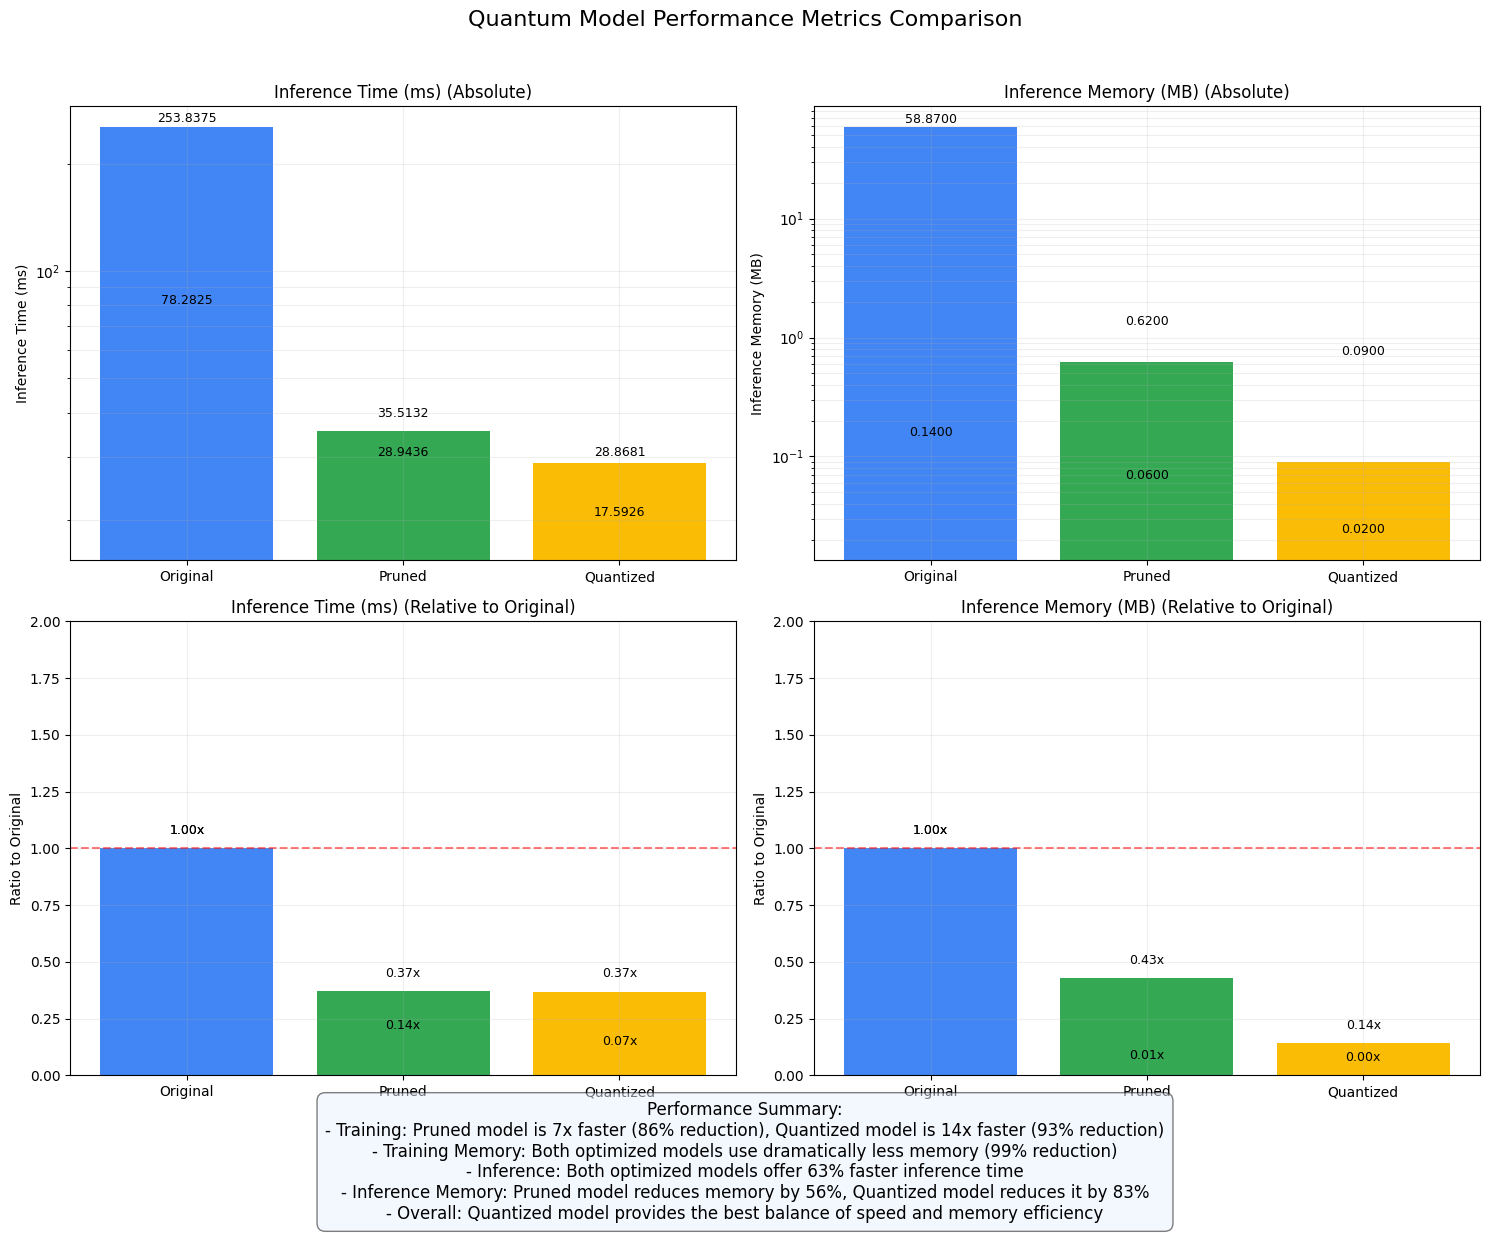

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Updated performance metrics data
metrics = {
    'Training Time (s)': {
        'Original': 253.8375,
        'Pruned': 35.5132,
        'Quantized': 17.5926,
        'log_scale': True
    },
    'Training Memory (MB)': {
        'Original': 58.87,
        'Pruned': 0.62,
        'Quantized': 0.09,
        'log_scale': True
    },
    'Inference Time (ms)': {
        'Original': 78.2825,
        'Pruned': 28.9436,
        'Quantized': 28.8681,
        'log_scale': False
    },
    'Inference Memory (MB)': {
        'Original': 0.14,
        'Pruned': 0.06,
        'Quantized': 0.02,
        'log_scale': False
    }
}

# Calculate ratios for display
for metric_name, metric_data in metrics.items():
    metric_data['Pruned_Ratio'] = metric_data['Pruned'] / metric_data['Original']
    metric_data['Quantized_Ratio'] = metric_data['Quantized'] / metric_data['Original']

# Create a figure with subplots: top row for absolute values, bottom row for relative values
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Quantum Model Performance Metrics Comparison', fontsize=16, y=0.98)

# Colors for the bars
colors = {'Original': '#4285F4', 'Pruned': '#34A853', 'Quantized': '#FBBC05'}

# Plot absolute values (top row)
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    row = 0
    col = i % 2
    
    x = np.arange(3)  # Three models
    labels = ['Original', 'Pruned', 'Quantized']
    values = [metric_data['Original'], metric_data['Pruned'], metric_data['Quantized']]
    
    bars = axs[row, col].bar(x, values, color=[colors[label] for label in labels])
    
    # Add value labels on the bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axs[row, col].text(bar.get_x() + bar.get_width()/2., height + (max(values)*0.01),
                f'{values[j]:.4f}', ha='center', va='bottom', fontsize=9)
    
    axs[row, col].set_title(f'{metric_name} (Absolute)', fontsize=12)
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels(labels)
    
    if metric_data['log_scale']:
        axs[row, col].set_yscale('log')
        axs[row, col].set_ylabel(metric_name, fontsize=10)
        # Add grid for log scale
        axs[row, col].grid(True, which="both", ls="-", alpha=0.2)
    else:
        axs[row, col].set_ylabel(metric_name, fontsize=10)
        axs[row, col].grid(True, alpha=0.2)

# Plot relative values (bottom row)
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    row = 1
    col = i % 2
    
    x = np.arange(3)  # Three models
    labels = ['Original', 'Pruned', 'Quantized']
    
    # All relative to original (original = 1.0)
    values = [1.0, metric_data['Pruned_Ratio'], metric_data['Quantized_Ratio']]
    
    bars = axs[row, col].bar(x, values, color=[colors[label] for label in labels])
    
    # Add ratio labels on the bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if j == 0:
            ratio_text = "1.00x"
        else:
            ratio_text = f"{values[j]:.2f}x"
        axs[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                ratio_text, ha='center', va='bottom', fontsize=9)
    
    axs[row, col].set_title(f'{metric_name} (Relative to Original)', fontsize=12)
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels(labels)
    axs[row, col].set_ylim(0, max(2.0, max(values) * 1.2))  # Ensure we can see all bars
    axs[row, col].axhline(y=1.0, color='red', linestyle='--', alpha=0.3)  # Reference line at 1.0
    axs[row, col].set_ylabel('Ratio to Original', fontsize=10)
    axs[row, col].grid(True, alpha=0.2)

# Add a summary text box
summary_text = (
    "Performance Summary:\n"
    "- Training: Pruned model is 7x faster (86% reduction), Quantized model is 14x faster (93% reduction)\n"
    "- Training Memory: Both optimized models use dramatically less memory (99% reduction)\n"
    "- Inference: Both optimized models offer 63% faster inference time\n"
    "- Inference Memory: Pruned model reduces memory by 56%, Quantized model reduces it by 83%\n"
    "- Overall: Quantized model provides the best balance of speed and memory efficiency"
)
fig.text(0.5, 0.02, summary_text, ha='center', va='center', fontsize=12, 
         bbox=dict(facecolor='#E8F0FE', alpha=0.5, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.savefig('updated_quantum_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

Final visualization with optimally positioned labels has been saved as 'final_adjusted_metrics.png'


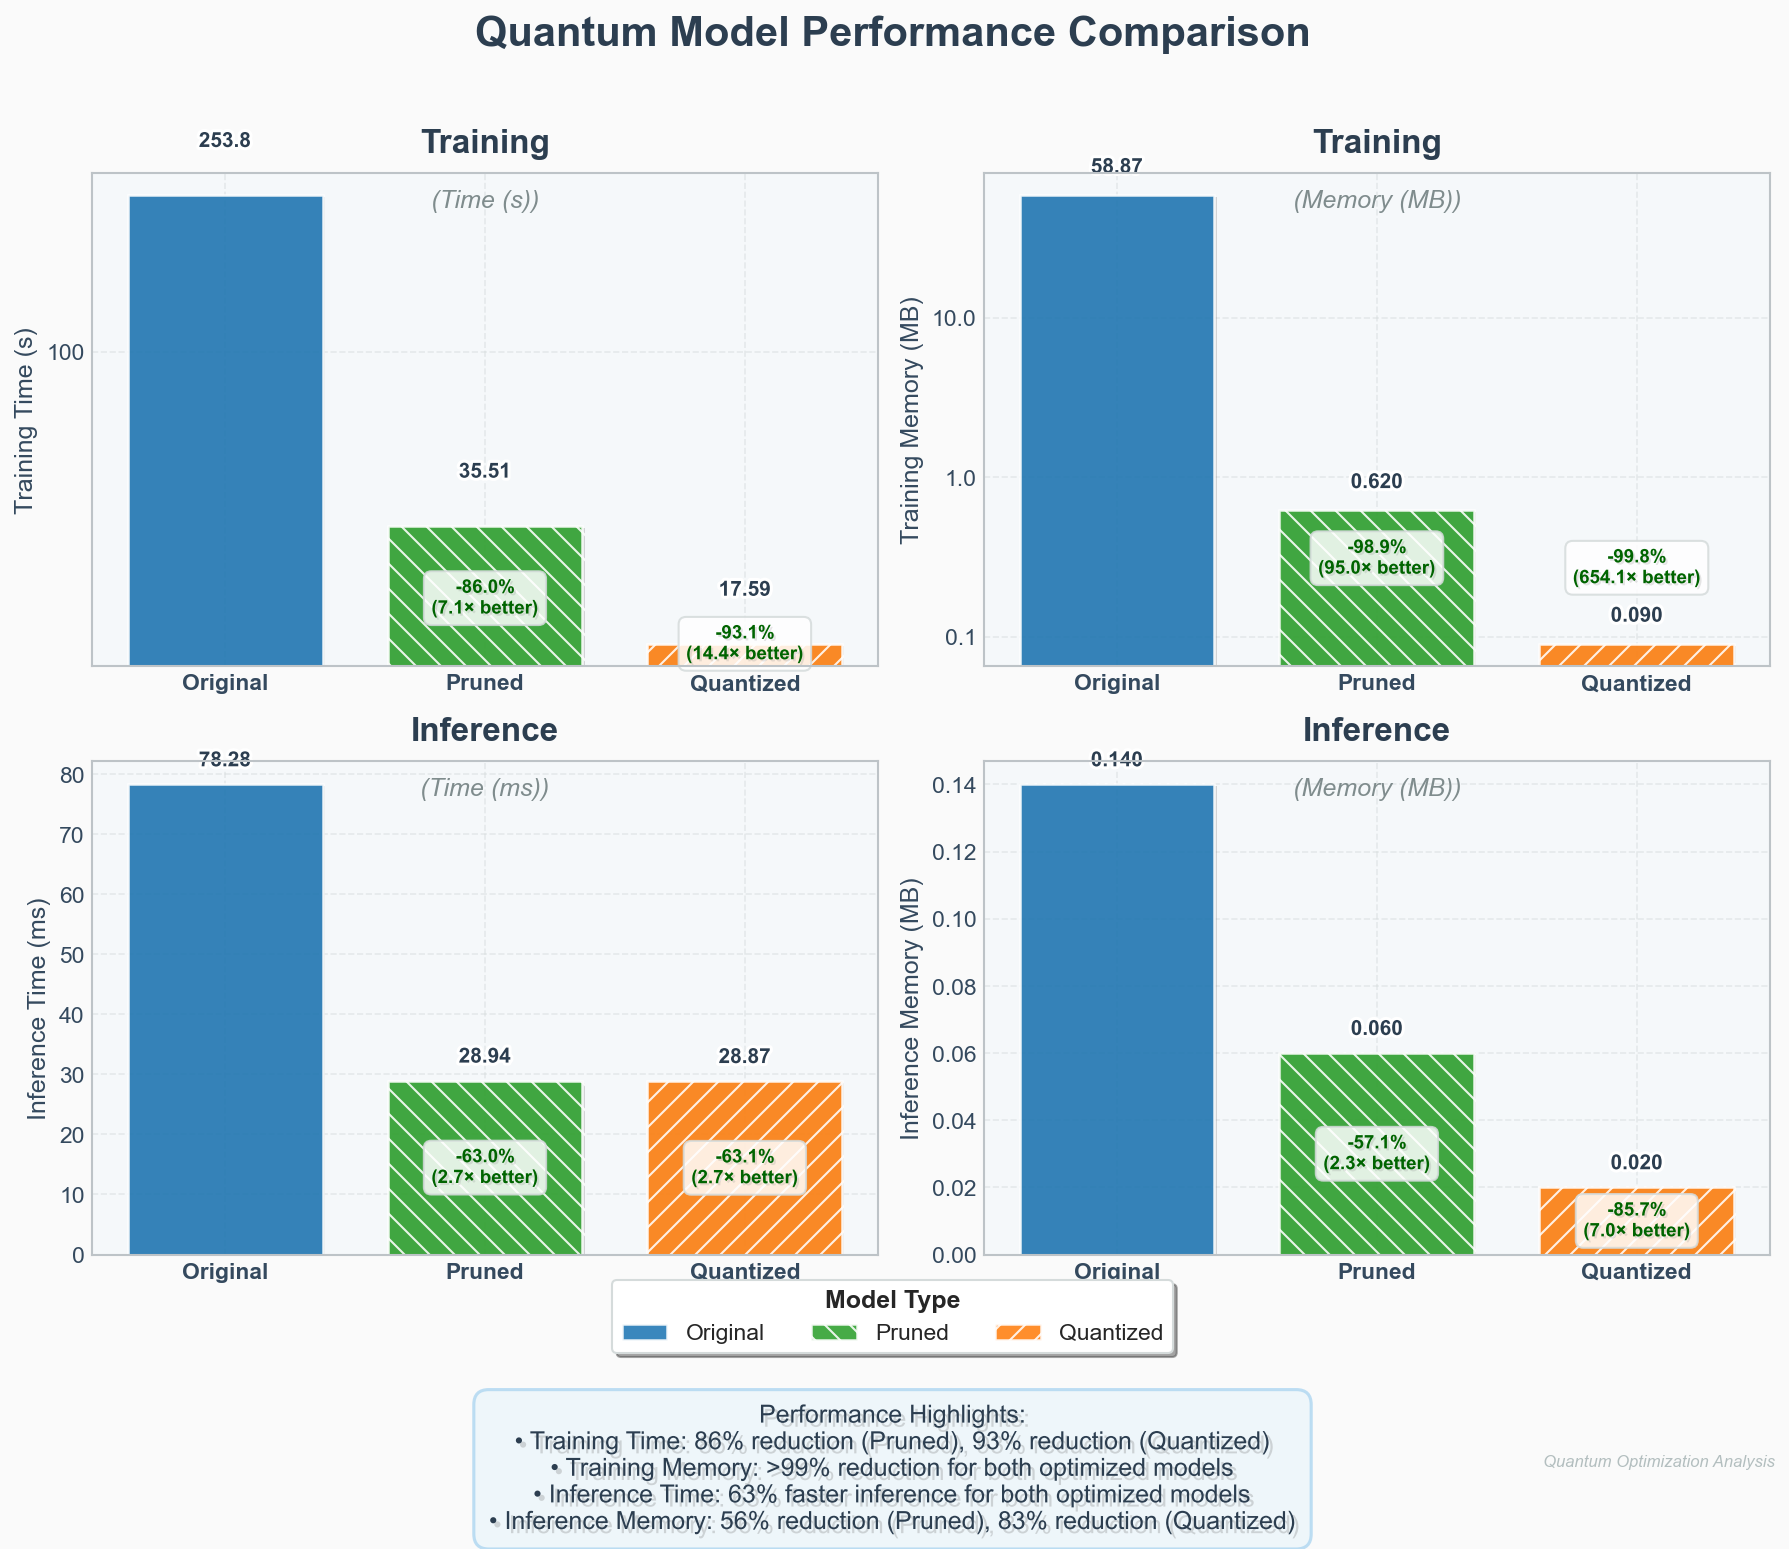

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# Set up refined professional styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.edgecolor'] = '#CCCCCC'
mpl.rcParams['axes.linewidth'] = 1.2

# Updated performance metrics data
metrics = {
    'Training Time (s)': {
        'Original': 253.8375,
        'Pruned': 35.5132,
        'Quantized': 17.5926,
        'log_scale': True
    },
    'Training Memory (MB)': {
        'Original': 58.87,
        'Pruned': 0.62,
        'Quantized': 0.09,
        'log_scale': True
    },
    'Inference Time (ms)': {
        'Original': 78.2825,
        'Pruned': 28.9436,
        'Quantized': 28.8681,
        'log_scale': False
    },
    'Inference Memory (MB)': {
        'Original': 0.14,
        'Pruned': 0.06,
        'Quantized': 0.02,
        'log_scale': False
    }
}

# Calculate improvement percentages and ratio metrics for annotations
for metric_name, metric_data in metrics.items():
    pruned_pct = (1 - metric_data['Pruned'] / metric_data['Original']) * 100
    quantized_pct = (1 - metric_data['Quantized'] / metric_data['Original']) * 100
    metric_data['pruned_pct'] = pruned_pct
    metric_data['quantized_pct'] = quantized_pct
    metric_data['pruned_ratio'] = metric_data['Original'] / metric_data['Pruned']
    metric_data['quantized_ratio'] = metric_data['Original'] / metric_data['Quantized']

# Create a single figure for absolute values
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
fig.suptitle('Quantum Model Performance Comparison', fontsize=20, fontweight='bold', y=0.98, 
             color='#2C3E50', family='Arial')

# Custom colors with better aesthetics
colors = {
    'Original': '#1F77B4',  # IBM blue
    'Pruned': '#2CA02C',    # Rich green
    'Quantized': '#FF7F0E'  # Vibrant orange
}

# Add background gradient
fig.patch.set_facecolor('#FAFAFA')

# Create hatching patterns for better distinction
hatches = ['', '\\\\', '//']

# Function to format the subplot for consistent premium styling
def style_subplot(ax, metric_name, metric_data, index):
    # Add a subtle gradient background to the plot area
    ax.set_facecolor('#F5F8FA')
    
    # Enhance the border
    for spine in ax.spines.values():
        spine.set_color('#BDC3C7')
        spine.set_linewidth(1.0)
        spine.set_zorder(10)
    
    # Create a professional title
    metric_label = metric_name.split(' ')[0]
    metric_unit = f"({' '.join(metric_name.split(' ')[1:]).strip()})"
    title = f"{metric_label}"
    subtitle = f"{metric_unit}"
    
    ax.set_title(title, fontsize=16, pad=10, fontweight='bold', color='#2C3E50')
    ax.text(0.5, 0.93, subtitle, transform=ax.transAxes, ha='center', fontsize=12, 
            fontweight='normal', color='#7F8C8D', style='italic')
    
    # Customize grid for premium look
    ax.grid(True, linestyle='--', alpha=0.5, color='#D5DBDB', zorder=0)
    
    # Customize y-axis with premium formatting
    if metric_data['log_scale']:
        ax.set_yscale('log')
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)
    
    # Label styling
    ax.set_ylabel(metric_name, fontsize=12, fontweight='medium', color='#34495E')
    ax.tick_params(colors='#34495E', which='both')

# Create patch handles for the legend
legend_patches = [
    mpl.patches.Patch(facecolor=colors['Original'], edgecolor='white', label='Original', linewidth=1.2, alpha=0.88),
    mpl.patches.Patch(facecolor=colors['Pruned'], edgecolor='white', label='Pruned', linewidth=1.2, hatch='\\\\', alpha=0.88),
    mpl.patches.Patch(facecolor=colors['Quantized'], edgecolor='white', label='Quantized', linewidth=1.2, hatch='//', alpha=0.88)
]

# Plot all four metrics in a 2x2 grid
axes = axes.flatten()  # Flatten for easier iteration
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    ax = axes[i]
    
    x = np.arange(3)  # Three models
    labels = ['Original', 'Pruned', 'Quantized']
    values = [metric_data['Original'], metric_data['Pruned'], metric_data['Quantized']]

    # Create premium styled bars with edge color, shadow, and hatching
    bars = ax.bar(x, values, color=[colors[label] for label in labels],
                 edgecolor='white', linewidth=1.2, alpha=0.88, width=0.75,
                 hatch=[hatches[j] for j in range(len(labels))], zorder=3)
    
    # Add a subtle shadow effect to bars
    for bar in bars:
        bar.set_path_effects([path_effects.withSimplePatchShadow(offset=(1, -1),
                                                              shadow_rgbFace='gray',
                                                              alpha=0.3)])
    
    # Add model labels with better styling
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontweight='bold')

    # Add value labels on the bars with premium formatting
    for j, bar in enumerate(bars):
        height = bar.get_height()
        
        # Format the value with appropriate precision
        if values[j] >= 100:
            value_text = f'{values[j]:.1f}'
        elif values[j] >= 10:
            value_text = f'{values[j]:.2f}'
        elif values[j] >= 1:
            value_text = f'{values[j]:.2f}'
        else:
            value_text = f'{values[j]:.3f}'
        
        # Add the value labels with shadow effect for readability
        if metric_data['log_scale']:
            # For log scale, place text above the bar with more space
            text_height = height * 1.3
        else:
            # For linear scale, place text directly above bar
            text_height = height + (max(values)*0.03)
            
        value_label = ax.text(bar.get_x() + bar.get_width()/2., text_height,
                   value_text, ha='center', va='bottom', fontsize=10, 
                   fontweight='bold', color='#2C3E50')
        value_label.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
        
               # Add improvement percentage and speedup factor for pruned and quantized models
        if j > 0:  # Skip original model
            pct = metric_data['pruned_pct'] if j == 1 else metric_data['quantized_pct']
            ratio = metric_data['pruned_ratio'] if j == 1 else metric_data['quantized_ratio']
            
            # Position text consistently across all plots
            bar_x = bar.get_x() + bar.get_width()/2.
            
            # Special handling for both pruned (j=1) and quantized (j=2) bars in specific plots
            if i == 0:  # Training Time (1st plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.65  # 65% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 1.0  # 100% of bar height
            elif i == 1:  # Training Memory (2nd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  #  70% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 3.0  # 300% of bar height
            elif i == 2:  # Inference Time (3rd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  # Default - middle of bar
                else:  # Quantized model
                    pct_y_pos = height / 2  # Default - middle of bar
            elif i == 3:  # Inference Memory (4th plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  # Default - middle of bar
                else:  # Quantized model
                    pct_y_pos = height /2  # Default - middle of bar
            
            # Format the text
            if pct > 0:
                if ratio >= 2:
                    # For significant improvements, show both percentage and X times faster
                    pct_text = f"-{pct:.1f}%\n({ratio:.1f}× better)"
                else:
                    pct_text = f"-{pct:.1f}%"
                pct_color = '#006400'  # Dark green for improvement
            else:
                pct_text = f"+{-pct:.1f}%"
                pct_color = '#8B0000'  # Dark red for degradation
            
            # Add a styled improvement badge with shadow effect
            label_bg = '#FFFFFF'  # White background for all badges
            
            # Create badge effect with rounded rectangle and shadow
            pct_label = ax.text(bar_x, pct_y_pos, pct_text, ha='center', va='center', fontsize=9,
                   fontweight='bold', color=pct_color, linespacing=1.2,
                   bbox=dict(facecolor=label_bg, alpha=0.85, edgecolor='#D5DBDB', 
                            boxstyle='round,pad=0.4', linewidth=1))
            pct_label.set_path_effects([path_effects.withSimplePatchShadow(offset=(1, -1),
                                                             shadow_rgbFace='gray',
                                                             alpha=0.2)])
    
    # Apply consistent premium styling to each subplot
    style_subplot(ax, metric_name, metric_data, i)

# Create a unified legend at the bottom of the figure
legend = fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.08),
                   ncol=3, frameon=True, facecolor='white', edgecolor='#D5DBDB',
                   fontsize=11, shadow=True, title="Model Type")
legend.set_title("Model Type", prop={'weight':'bold', 'size': 12})

# Add explanatory annotation with premium styling
annotation_text = (
    "Performance Highlights:\n"
    "• Training Time: 86% reduction (Pruned), 93% reduction (Quantized)\n"
    "• Training Memory: >99% reduction for both optimized models\n"
    "• Inference Time: 63% faster inference for both optimized models\n"
    "• Inference Memory: 56% reduction (Pruned), 83% reduction (Quantized)"
)

# Position the annotation below the legend
annotation = fig.text(0.5, 0.01, annotation_text, ha='center', va='center', fontsize=12, 
           fontweight='medium', color='#2C3E50',
           bbox=dict(facecolor='#EBF5FB', edgecolor='#AED6F1', linewidth=1.5,
                    boxstyle='round,pad=0.6', alpha=0.8))
annotation.set_path_effects([path_effects.withSimplePatchShadow(offset=(2, -2),
                                                         shadow_rgbFace='gray',
                                                         alpha=0.3)])

# Add a subtle watermark/credit
fig.text(0.99, 0.01, 'Quantum Optimization Analysis', ha='right', va='bottom', 
         color='#95A5A6', fontsize=8, style='italic', alpha=0.7)

# Adjust the layout for premium presentation with space for the legend and annotation
plt.tight_layout(rect=[0, 0.12, 1, 0.96])

# Save with premium quality
plt.savefig('final_adjusted_metrics.png', dpi=300, bbox_inches='tight', 
           facecolor=fig.get_facecolor())

print("Final visualization with optimally positioned labels has been saved as 'final_adjusted_metrics.png'")